In [ ]:
pip install transformers datasets torch accelerate peft
pip install kagglehub
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ------------- -------------------------- 2.6/7.8 MB 13.7 MB/s eta 0:00:01
   ----------------------------- ---------- 5.8/7.8 MB 13.6 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 12.7 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 12.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [106]:
import kagglehub
import pandas as pd
import os, json
from textwrap import dedent
from typing import Dict
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import numpy as np
from sklearn.model_selection import train_test_split

from transformers import AutoModelForCausalLM, TrainingArguments, AutoTokenizer, BitsAndBytesConfig, pipeline
from trl import SFTTrainer
from peft import LoraConfig, get_peft_model
from datasets import load_dataset
import torch

In [57]:
model_id = r"C:\Users\Joshua\Desktop\python_ai\llm_code\llama31\Llama-3.1-8B-Instruct"

# Loading model
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16, #float16
    bnb_4bit_quant_type="nf4"
) # INSPECT MORE

llm_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_id,
    quantization_config=quantization_config
)

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Training arguments
training_arguments = TrainingArguments(
    output_dir="./test_trainer",
    num_train_epochs=4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    gradient_checkpointing=True,
    optim="paged_adamw_32bit",
    save_steps=1000,
    save_total_limit=2,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

# Fine tunning
# Optimize training
peft_config = LoraConfig(
    task_type = "CAUSAL_LM", 
    r = 64, #64
    lora_alpha = 16, #16
    lora_dropout = 0.1 #0.1
)
#llm_model = get_peft_model(llm_model, peft_config)



`low_cpu_mem_usage` was None, now default to True since model is quantized.
Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]c:\Users\Joshua\Desktop\python_ai\.venv\Lib\site-packages\accelerate\utils\modeling.py:329: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  new_value = value.to(device)
Loading checkpoint shards: 100%|██████████| 4/4 [01:02<00:00, 15.56s/it]


In [ ]:
# Start Training with dataset
finetune_dataset = load_dataset(path=dataset, split="train") # GO OVER

def formatting_func(example):
    output_texts = []
    for i in range(len(example['input'])):
        text = f"### Input: {example['input'][i]}\n ### Output: {example['output'][i]}\n ### Instruction: {example['instruction'][i]}\n ### Prompt: {example['prompt'][i]}"
        output_texts.append(text)
    return output_texts


llm_model_trainer = SFTTrainer(
    model=llm_model,
    args=training_arguments,
    train_dataset=load_dataset(path = "Shekswess/llama3_medical_meadow_wikidoc_instruct_dataset", split = "train"),
    tokenizer=tokenizer,
    peft_config = peft_config,
    formatting_func=formatting_func,
)

# Start training
latest_checkpoint = "./test_trainer/checkpoint-10000"

if latest_checkpoint:
    print(f"Resuming training from checkpoint: {latest_checkpoint}")
    llm_model_trainer.train(resume_from_checkpoint=latest_checkpoint)
else:
    print("Starting training from scratch")
    llm_model_trainer.train()

# Pipeline for taking in inputs
pipeline = pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device="cuda",
)


# Prompting


while True:
    user_prompt = input("What's your question?\n")
    if user_prompt == "exit":
        break
    # messages = [
    # {"role": "system", "content": (
    #     "You are a highly knowledgeable mathematician and engineering chatbot. "
    #         "Your purpose is to assist users by providing detailed, scientifically accurate explanations of mathematical and engineering concepts. "
    #         "Use formal scientific language and precise terminology, ensuring your responses are comprehensive and thorough. "
    #         "Reference relevant theories, equations, and examples as needed, but keep your explanations strictly text-based. "
    #         "Organize your answers clearly, and aim to enhance understanding by elucidating complex concepts without oversimplifying them."
    #     )},
    # {"role": "user", "content": user_prompt}]

    outputs = pipeline(user_prompt,max_new_tokens=256)
    responce = outputs[0]["generated_text"]
    print(responce)

print("Exiting...")

In [11]:
dataset_path = kagglehub.dataset_download("mathurinache/math-dataset")
print(dataset_path)

100%|██████████| 7.07M/7.07M [00:01<00:00, 5.02MB/s]

Extracting files...


C:\Users\Joshua\.cache\kagglehub\datasets\mathurinache\math-dataset\versions\1


In [ ]:
training_path = r"C:\Users\Joshua\Desktop\python_ai\llm_code\datasets\MATH\train"
testing_path = r"C:\Users\Joshua\Desktop\python_ai\llm_code\datasets\MATH\test"

def load_data(file_path):
    dataset = {}
    for problemType in os.listdir(file_path):
        problemTypePath = os.path.join(file_path, problemType)
        problems = []
        for problem in os.listdir(problemTypePath):
            filePath = os.path.join(problemTypePath, problem)
            with open(filePath, 'r') as file:
                fileContents = json.load(file)
                problems.append(fileContents)
        dataset[problemType] = problems
    return dataset

dataset = {
    "train":load_data(training_path),
    "test":load_data(testing_path)
}

print("Training")
for problemType, problems in dataset["train"].items():
    print(f"Category: {problemType}, Problems Loaded: {len(problems)}")

print("Testing")
for problemType, problems in dataset["test"].items():
    print(f"Category: {problemType}, Problems Loaded: {len(problems)}")

Training
Category: algebra, Problems Loaded: 1744
Category: counting_and_probability, Problems Loaded: 771
Category: geometry, Problems Loaded: 870
Category: intermediate_algebra, Problems Loaded: 1295
Category: number_theory, Problems Loaded: 869
Category: prealgebra, Problems Loaded: 1205
Category: precalculus, Problems Loaded: 746
Testing
Category: algebra, Problems Loaded: 1187
Category: counting_and_probability, Problems Loaded: 474
Category: geometry, Problems Loaded: 479
Category: intermediate_algebra, Problems Loaded: 903
Category: number_theory, Problems Loaded: 540
Category: prealgebra, Problems Loaded: 871
Category: precalculus, Problems Loaded: 546


In [89]:
combined_dataset = {}
for problemType, problems in load_data(training_path).items():
    if problemType in combined_dataset:
        combined_dataset[problemType].extend(problems)
    else:
        combined_dataset[problemType] = problems

for problemType, problems in load_data(testing_path).items():
    if problemType in combined_dataset:
        combined_dataset[problemType].extend(problems)
    else:
        combined_dataset[problemType] = problems

print("Combined Dataset Summary:")
for problemType, problems in combined_dataset.items():
    print(f"Category: {problemType}, Total Problems: {len(problems)}")

Combined Dataset Summary:
Category: algebra, Total Problems: 2931
Category: counting_and_probability, Total Problems: 1245
Category: geometry, Total Problems: 1349
Category: intermediate_algebra, Total Problems: 2198
Category: number_theory, Total Problems: 1409
Category: prealgebra, Total Problems: 2076
Category: precalculus, Total Problems: 1292


In [90]:
context_mapping = {
        "algebra": "Solve equations, simplify expressions, and analyze mathematical relationships.",
        "geometry": "Study shapes, sizes, and the properties of space and figures.",
        "prealgebra": "Build foundational skills for algebra, such as basic arithmetic and simple equations.",
        "number theory": "Explore properties of numbers, divisibility, and prime numbers.",
        "counting & probability": "Analyze counting methods and calculate probabilities.",
        "precalculus": "Prepare for calculus by studying functions, limits, and trigonometry.",
        "intermediate algebra": "Work on advanced algebraic concepts like quadratic equations and functions."
    }

rows = []
for category, problems in combined_dataset.items():
    for item in problems:
        rows.append(
            {
                "question": item["problem"],
                "context": context_mapping.get(category.lower(), "Explore mathematical concepts."),
                "answer": item["solution"]
            }
        )

df = pd.DataFrame(rows)

In [91]:
df.head()
df.isnull().value_counts()

question  context  answer
False     False    False     12500
Name: count, dtype: int64

In [92]:
def format_dataset(row: dict):
    prompt = dedent(
        f"""
    {row["question"]}

    Information:

    ```
    {row["context"]}
    ```
    """
    )
    messages = [
        {
            "role":"system",
            "content": "Use only the information to answer the question",
        },
        {"role":"user", "content": prompt},
        {"role":"assistant", "content": row["answer"]},
    ]
    return tokenizer.apply_chat_template(messages, tokenize=False)

In [93]:
df["text"] = df.apply(format_dataset, axis=1)

In [94]:
def count_tokens(row: Dict) -> int:
    return len(
        tokenizer(
            row["text"],
            add_special_tokens=True,
            return_attention_mask=False,
        )["input_ids"]
    )

In [95]:
df["token_count"] = df.apply(count_tokens, axis=1)

In [96]:
df.head()

,question,context,answer,text,token_count
0,"Let \[f(x) = \left\{\n\begin{array}{cl} ax+3, ...","Solve equations, simplify expressions, and ana...","For the piecewise function to be continuous, t...",<|begin_of_text|><|start_header_id|>system<|en...,305
1,A rectangular band formation is a formation wi...,"Solve equations, simplify expressions, and ana...",Let $x$ be the number of band members in each ...,<|begin_of_text|><|start_header_id|>system<|en...,430
2,What is the degree of the polynomial $(4 +5x^3...,"Solve equations, simplify expressions, and ana...",This polynomial is not written in standard for...,<|begin_of_text|><|start_header_id|>system<|en...,175
3,Evaluate $\left\lceil3\left(6-\frac12\right)\r...,"Solve equations, simplify expressions, and ana...","Firstly, $3\left(6-\frac12\right)=18-1-\frac12...",<|begin_of_text|><|start_header_id|>system<|en...,144
4,Sam is hired for a 20-day period. On days that...,"Solve equations, simplify expressions, and ana...",Call $x$ the number of days Sam works and $y$ ...,<|begin_of_text|><|start_header_id|>system<|en...,313


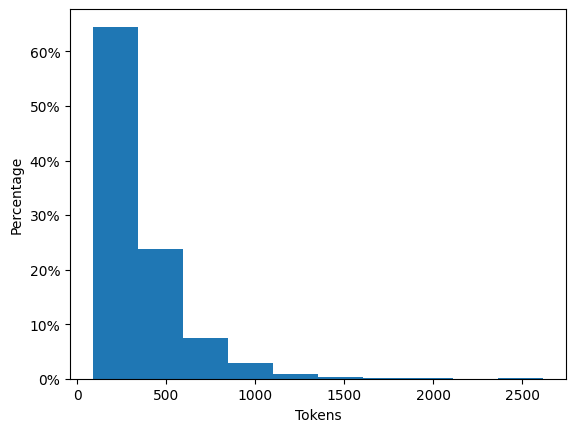

In [97]:
plt.hist(df.token_count, weights=np.ones(len(df.token_count)) / len(df.token_count))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xlabel("Tokens")
plt.ylabel("Percentage")
plt.show()

In [104]:
# Tell us the length
len(df[df.token_count < 512]), len(df), len(df[df.token_count < 1550]) / len(df)

(5031, 6000, 1.0)

In [105]:
df = df[df.token_count < 1400]
df = df.sample(6000)
df.shape

(6000, 5)

In [ ]:
train, temp = train_test_split(df, test_size=0.2)
val, test = train_test_split(temp, test_size=0.2)

train.sample(n=4000).to_json("split_sets/train.json", orient="records", lines=True)
val.sample(n=500).to_json("split_sets/val.json", orient="records", lines=True)
test.sample(n=100).to_json("split_sets/test.json", orient="records", lines=True)

In [114]:
dataset = load_dataset(
    "json",
    data_files={"train": "split_sets/train.json", "validation": "split_sets/val.json", "test": "split_sets/test.json"},
)

Generating train split: 4000 examples [00:00, 61119.85 examples/s]
Generating validation split: 500 examples [00:00, 55565.47 examples/s]
Generating test split: 100 examples [00:00, 14283.83 examples/s]


In [ ]:
#https://www.youtube.com/watch?v=0XPZlR3_GgI
# 14:20